- Load data

  Unzips the movielens zip file. This file should be stored in a folder named "folder"
- Graphs
  - Long tail overlooked

    Displays the graph for overlooked long tail items which is used to determine if there is mainstreamness in user choices

  - Cumulative Distribution of Movie Ratings

    Displays the graph for distribution of movie ratings. This is used to determine what should be the range to determine if item is popular, diverse or niche

  - Globally popular items(movies)

    This creates list of popular movies using the mean ratings and number of ratings

  - Popular genres

    Creates a graph to display genres from the movielens dataset to determine what are mainstream genres

  - Activeness

    Contains activeness related code which also generates the user activeness heatmap

- Final Code
    - Set Parameters
      
      Sets the user id which is used to fetch necessary records. (Eg: in case of recommendation algorithm, it fetches the recommended movies for the user based on the user id)
    - KNN user based

      Fetches KNN user based recommendations from csv file based on the user id
    - MF

      Fetches Matrix Factorization recommendations from csv file based on the user id
    - KNN item based

      Fetches KNN item based recommendations from csv file based on the user id
    - VAE

      Fetches Variational autoencoder recommendations from csv file based on the user id
    - preference distortion graph

      Contains the necessary code to calculate genre distribution and plot actual vs recommendation bar graphs
    - preference distortion based on genre distribution

      Contains graphs using "preference distortion graph" and recommendations generated from any of the recommendation model sections specified. Displays genre distribution graphs in dataset and recommendation set as well as for a particular user

    - Activeness

      Additional activeness related code like getting list of top 10 active users by creating implicit feedback dataset and list of active mainstream users

    - Genre distribution for recommended movies

      Graph to create bar plot based on just one list. Here we use this to display genre distribution just for recommended items.

Note: If the sections in the final code need recommendation list then execute one of the sections of the recommendation algorithms. csv files needed in recommendation model sections follow ['UserID', 'MovieID','Title','genres','Prediction_Rating'] format. For VAE, it is ['UserID', 'MovieID'] but here MovieID is a list of movie ids

###Load data

In [1]:
! unzip folder/ml-1m.zip

Archive:  folder/ml-1m.zip
   creating: ml-1m/
  inflating: ml-1m/movies.dat        
  inflating: ml-1m/ratings.dat       
  inflating: ml-1m/README            
  inflating: ml-1m/users.dat         


##Graphs

###Long tail overlooked

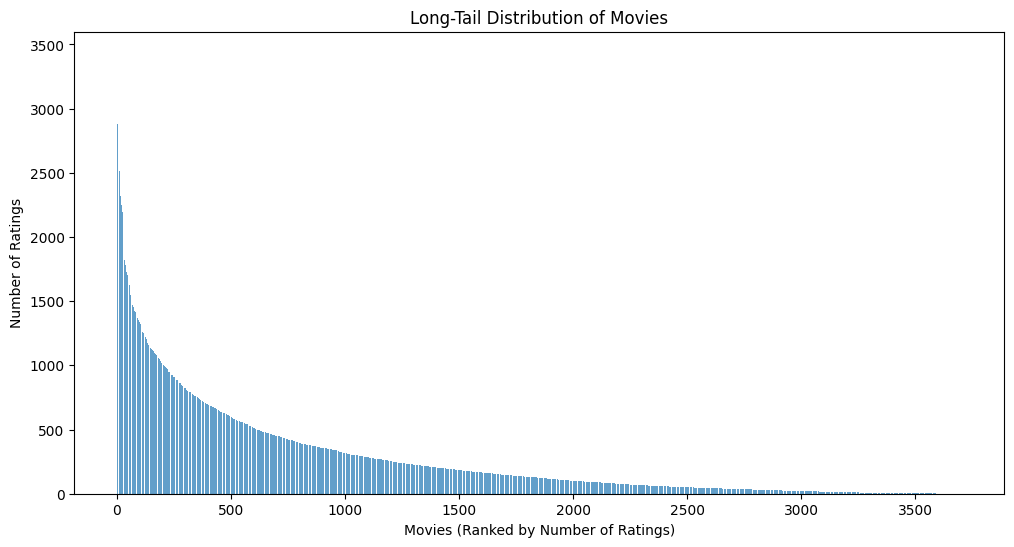

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Assuming you have a DataFrame with movie ratings, and you want to analyze the distribution of movie ratings
# Replace 'ratings_df' with your actual DataFrame
ratings_df = pd.read_csv('ml-1m/ratings.dat', sep='::', names=['UserID', 'MovieID', 'Rating', 'Timestamp'], engine='python', encoding='ISO-8859-1')

movie_ratings_count = ratings_df['MovieID'].value_counts()

# Sort the movies by the number of ratings in descending order
sorted_movie_ratings = movie_ratings_count.sort_values(ascending=False)

# Plot the long-tail distribution
plt.figure(figsize=(12, 6))
plt.bar(range(len(sorted_movie_ratings)), sorted_movie_ratings, alpha=0.7)
plt.xlabel('Movies (Ranked by Number of Ratings)')
plt.ylabel('Number of Ratings')
plt.title('Long-Tail Distribution of Movies')
plt.show()


###Cumulative Distribution of Movie Ratings

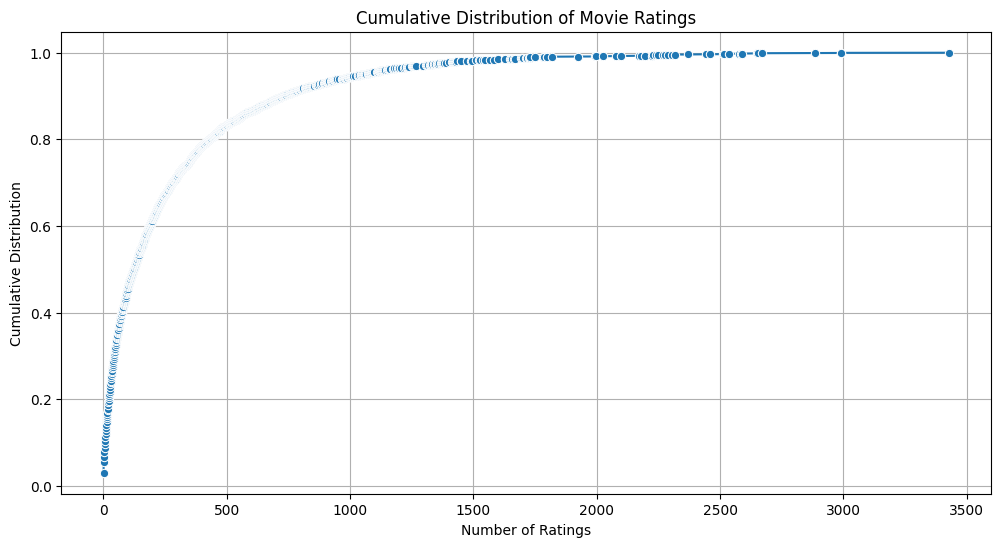

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming you have a DataFrame with movie ratings, and you want to analyze the distribution of movie ratings
# Replace 'ratings_df' with your actual DataFrame
ratings_df = pd.read_csv('ml-1m/ratings.dat', sep='::', names=['UserID', 'MovieID', 'Rating', 'Timestamp'], engine='python', encoding='ISO-8859-1')

# Count the number of ratings each movie received
movie_ratings_count = ratings_df['MovieID'].value_counts()

# Calculate cumulative distribution
cumulative_distribution = movie_ratings_count.value_counts(normalize=True).sort_index().cumsum()

# Plot the cumulative distribution
plt.figure(figsize=(12, 6))
sns.lineplot(x=cumulative_distribution.index, y=cumulative_distribution.values, marker='o')
plt.xlabel('Number of Ratings')
plt.ylabel('Cumulative Distribution')
plt.title('Cumulative Distribution of Movie Ratings')
plt.grid(True)
plt.show()

In [43]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming you have a DataFrame with movie ratings
ratings_df = pd.read_csv('ml-1m/ratings.dat', sep='::', names=['UserID', 'MovieID', 'Rating', 'Timestamp'], engine='python', encoding='ISO-8859-1')

# Assuming you have already categorized movies into niche, diverse, and popular based on the number of ratings
# You can adjust these thresholds based on your analysis
niche_threshold = 250
diverse_threshold = 1400

# Count the number of ratings each movie received
movie_ratings_count = ratings_df['MovieID'].value_counts()

# Categorize movies
ratings_df['Category'] = 'Popular'
ratings_df.loc[ratings_df['MovieID'].isin(movie_ratings_count[movie_ratings_count <= niche_threshold].index), 'Category'] = 'Niche'
ratings_df.loc[(ratings_df['MovieID'].isin(movie_ratings_count[movie_ratings_count > niche_threshold].index)) &
                (ratings_df['MovieID'].isin(movie_ratings_count[movie_ratings_count <= diverse_threshold].index)), 'Category'] = 'Diverse'

# Calculate the number of movies watched by each user in each category
user_movie_counts = ratings_df.groupby(['UserID', 'Category']).size().unstack(fill_value=0)

# Calculate the total number of movies watched by each user
user_total_movies = user_movie_counts.sum(axis=1)

# Calculate the percentage of movies in each category for each user
user_percentage_movies = user_movie_counts.div(user_total_movies, axis=0) * 100

# Establish thresholds for categorization (adjust as needed)
niche_threshold_percentage = 30
diverse_threshold_percentage = 60

# Categorize users based on the percentage of movies in each category
user_categories = pd.Series(index=user_percentage_movies.index, dtype='object')
user_categories[user_percentage_movies['Niche'] >= niche_threshold_percentage] = 'Niche'
user_categories[(user_percentage_movies['Niche'] < niche_threshold_percentage) & (user_percentage_movies['Diverse'] >= diverse_threshold_percentage)] = 'Diverse'
user_categories[user_categories.isna()] = 'Popular'

# Print or use the user_categories Series as needed
# print(user_categories)
# # Save user categories to a CSV file
# user_categories.to_csv('user_categories.csv', header=['Category'])
# print("User categories saved to 'user_categories.csv'")

UserID
1       Diverse
2       Diverse
3       Popular
4       Popular
5       Popular
         ...   
6036      Niche
6037    Diverse
6038    Diverse
6039    Diverse
6040    Diverse
Length: 6040, dtype: object
User categories saved to 'user_categories.csv'


###Globally popular items(movies)

In [ ]:
# ! unzip folder/ml-1m.zip
ratings_data = pd.read_csv('ml-1m/ratings.dat', sep='::', engine='python', header=None, names=['UserID','MovieID', 'Rating', 'timestamp'], encoding='ISO-8859-1')

# Load movie information
movies_df = pd.read_csv('ml-1m/movies.dat', sep='::', engine='python', header=None, names=['MovieID', 'Title', 'genres'], encoding='ISO-8859-1')

# Merge movies and ratings dataframes
movie_ratings = pd.merge(ratings_data, movies_df, on='MovieID')

In [ ]:
# Calculate mean ratings and count of ratings for each movie
movie_stats = movie_ratings.groupby(['Title', 'genres']).agg({'Rating': ['mean', 'count']}).reset_index()

# Rename columns for better readability
movie_stats.columns = ['title', 'genres', 'mean_rating', 'num_ratings']

# Sort movies in descending order of mean ratings and number of ratings
movie_stats.sort_values(['num_ratings', 'mean_rating'], ascending=[False, False], inplace=True)

# Display the first 20 movies in tabular format
top_20_movies = movie_stats.head(20)
print(top_20_movies.to_markdown(index=False))

| title                                                 | genres                              |   mean_rating |   num_ratings |
|:------------------------------------------------------|:------------------------------------|--------------:|--------------:|
| American Beauty (1999)                                | Comedy|Drama                        |       4.31739 |          3428 |
| Star Wars: Episode IV - A New Hope (1977)             | Action|Adventure|Fantasy|Sci-Fi     |       4.45369 |          2991 |
| Star Wars: Episode V - The Empire Strikes Back (1980) | Action|Adventure|Drama|Sci-Fi|War   |       4.29298 |          2990 |
| Star Wars: Episode VI - Return of the Jedi (1983)     | Action|Adventure|Romance|Sci-Fi|War |       4.02289 |          2883 |
| Jurassic Park (1993)                                  | Action|Adventure|Sci-Fi             |       3.76385 |          2672 |
| Saving Private Ryan (1998)                            | Action|Drama|War                    |       4.

In [ ]:
# Filter ratings greater than 4
high_ratings = movie_ratings[movie_ratings['Rating'] > 4]

# Count the number of high ratings for each movie
high_ratings_count = high_ratings['MovieID'].value_counts().reset_index()
high_ratings_count.columns = ['MovieID', 'high_ratings_count']

# Merge with the movies dataframe to get movie information
result = pd.merge(high_ratings_count, movies_df, on='MovieID')

# Sort movies based on the number of high ratings in descending order
sorted_movies = result.sort_values(by='high_ratings_count', ascending=False)

# Display the list of movies in tabular format
print(sorted_movies[['Title', 'genres', 'high_ratings_count']].head(20).to_markdown(index=False))

| Title                                                 | genres                              |   high_ratings_count |
|:------------------------------------------------------|:------------------------------------|---------------------:|
| American Beauty (1999)                                | Comedy|Drama                        |                 1963 |
| Star Wars: Episode IV - A New Hope (1977)             | Action|Adventure|Fantasy|Sci-Fi     |                 1826 |
| Raiders of the Lost Ark (1981)                        | Action|Adventure                    |                 1500 |
| Star Wars: Episode V - The Empire Strikes Back (1980) | Action|Adventure|Drama|Sci-Fi|War   |                 1483 |
| Schindler's List (1993)                               | Drama|War                           |                 1475 |
| Godfather, The (1972)                                 | Action|Crime|Drama                  |                 1475 |
| Shawshank Redemption, The (1994)              

###Popular genres

In [ ]:
# Split the pipe-separated genres and explode them into separate rows
movie_ratings['genre'] = movie_ratings['genres'].str.split('|')
exploded_genres = movie_ratings.explode('genre')

# Count the number of ratings for each genre
genre_ratings_count = exploded_genres.groupby('genre')['Rating'].count().reset_index()
genre_ratings_count.columns = ['genre', 'num_ratings']

# Sort genres based on the number of ratings in descending order
sorted_genres = genre_ratings_count.sort_values(by='num_ratings', ascending=False)

# Display the list of genres in tabular format
print(sorted_genres.to_markdown(index=False))

| genre       |   num_ratings |
|:------------|--------------:|
| Comedy      |        356580 |
| Drama       |        354529 |
| Action      |        257457 |
| Thriller    |        189680 |
| Sci-Fi      |        157294 |
| Romance     |        147523 |
| Adventure   |        133953 |
| Crime       |         79541 |
| Horror      |         76386 |
| Children's  |         72186 |
| War         |         68527 |
| Animation   |         43293 |
| Musical     |         41533 |
| Mystery     |         40178 |
| Fantasy     |         36301 |
| Western     |         20683 |
| Film-Noir   |         18261 |
| Documentary |          7910 |


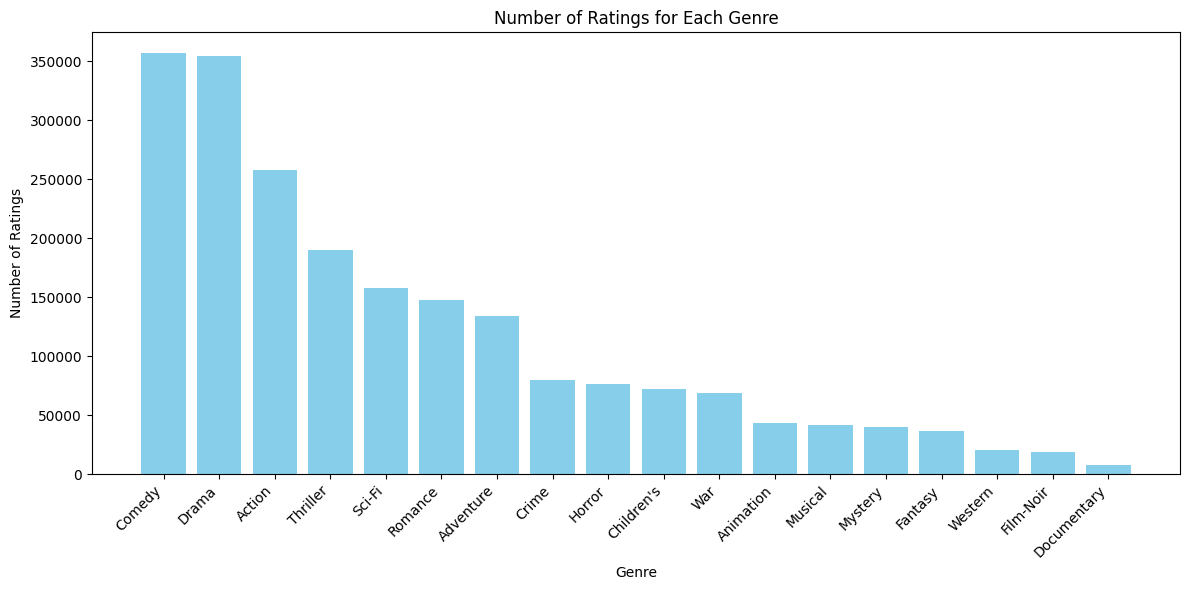

In [ ]:
# Plot the bar chart
plt.figure(figsize=(12, 6))
plt.bar(sorted_genres['genre'], sorted_genres['num_ratings'], color='skyblue')
plt.xlabel('Genre')
plt.ylabel('Number of Ratings')
plt.title('Number of Ratings for Each Genre')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

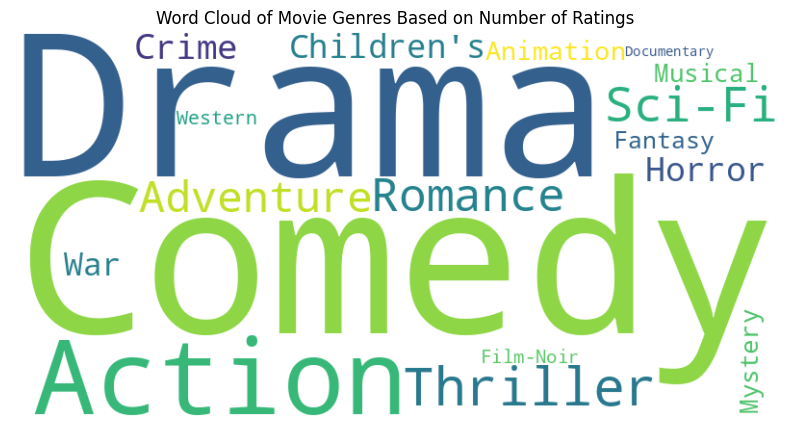

In [ ]:
import pandas as pd
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Create a dictionary from genre_ratings_count for word cloud
genre_dict = dict(zip(genre_ratings_count['genre'], genre_ratings_count['num_ratings']))

# Generate the word cloud
wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(genre_dict)

# Display the word cloud
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud of Movie Genres Based on Number of Ratings')
plt.show()

### Activeness

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the ratings data
data = pd.read_csv('ml-1m/ratings.dat', sep='::', engine='python', header=None, names=['UserID', 'MovieID', 'Rating', 'Timestamp'], encoding='ISO-8859-1')


data['Rating'] = data['Rating'].apply(lambda x: 1 if x > 0 else 0)


user_activeness = data.pivot(index='UserID', columns='MovieID', values='Rating').fillna(0)
user_activeness['Activeness'] = user_activeness.sum(axis=1)

In [ ]:
user_activeness = data.pivot(index='UserID', columns='MovieID', values='Rating').fillna(0)
user_activeness['Activeness'] = user_activeness.sum(axis=1)

# Get the top 20 most active users
top_users_df = user_activeness.nlargest(20, 'Activeness')[['Activeness']]

# Display the top 20 most active users in a table format
print(top_users_df.to_markdown())

|   UserID |   Activeness |
|---------:|-------------:|
|     4169 |         2314 |
|     1680 |         1850 |
|     4277 |         1743 |
|     1941 |         1595 |
|     1181 |         1521 |
|      889 |         1518 |
|     3618 |         1344 |
|     2063 |         1323 |
|     1150 |         1302 |
|     1015 |         1286 |
|     5795 |         1277 |
|     4344 |         1271 |
|     1980 |         1260 |
|     2909 |         1258 |
|     1449 |         1243 |
|     4510 |         1240 |
|      424 |         1226 |
|     4227 |         1222 |
|     5831 |         1220 |
|     3391 |         1216 |


<ipython-input-33-69ddf16b79a7>:4: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  ratings = pd.read_csv('ml-1m/ratings.dat', sep='::', names=['UserID', 'MovieID', 'Rating', 'Timestamp'])


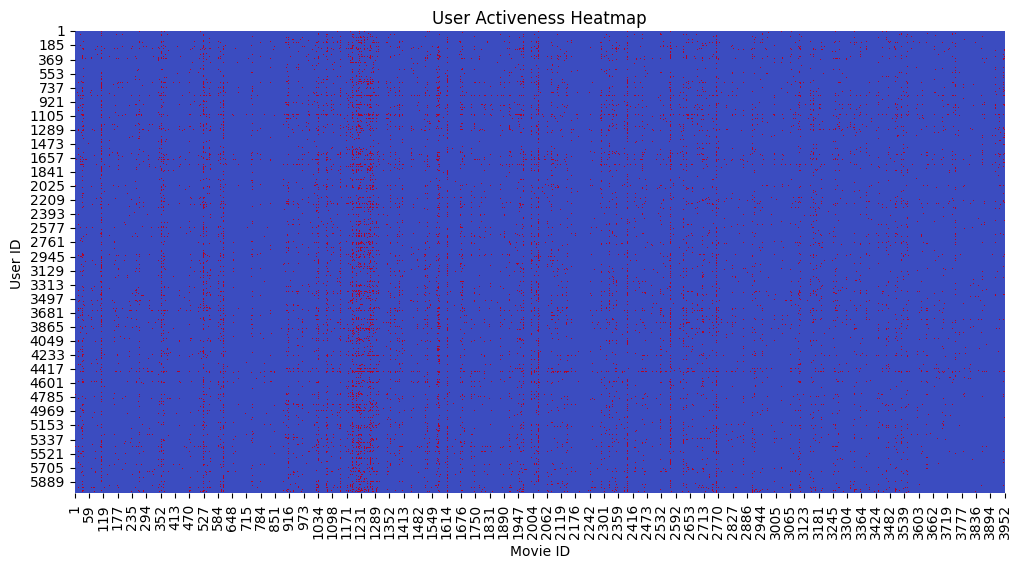

In [ ]:
import seaborn as sns

# Load the MovieLens-1M dataset
ratings = pd.read_csv('ml-1m/ratings.dat', sep='::', names=['UserID', 'MovieID', 'Rating', 'Timestamp'])

# Set a threshold to convert ratings into implicit feedback
threshold = 3.5
implicit_ratings = ratings.copy()
implicit_ratings['ImplicitRating'] = implicit_ratings['Rating'].apply(lambda x: 1 if x >= threshold else 0)

# Create a user-movie matrix from implicit ratings
user_movie_matrix = implicit_ratings.pivot(index='UserID', columns='MovieID', values='ImplicitRating')
user_movie_matrix.fillna(0, inplace=True)

# Create a heatmap to visualize user activeness
plt.figure(figsize=(12, 6))
sns.heatmap(user_movie_matrix, cbar=False, cmap='coolwarm')
plt.xlabel('Movie ID')
plt.ylabel('User ID')
plt.title('User Activeness Heatmap')
plt.show()

##Final Code

###Set parameters

In [29]:
userId = 850  # Replace with the desired user ID

### KNN user based

In [30]:
import pandas as pd

# Load the CSV file into a DataFrame
df = pd.read_csv('user_based_predictions_with_genres.csv', header=0,names=['UserID', 'MovieID','Prediction_Rating','Title','genres'])

# Filter the DataFrame for user ID 4485 and sort by predicted rating in descending order
user_df = df[df['UserID'] == userId].sort_values(by='Prediction_Rating', ascending=False)

# Extract the top 10 movie IDs based on predicted rating
top_10_rec_movies = user_df.head(10)['MovieID'].tolist()

# Display the top 10 movie IDs for user ID 4485
print(top_10_rec_movies)


[1106, 1110, 527, 1120, 1297, 1516, 1178, 1109, 1594, 1258]


###MF

In [37]:
import pandas as pd

# Load the CSV file into a DataFrame
df = pd.read_csv('MF_predictions_with_genres.csv', header=0,names=['UserID', 'MovieID','Title','genres','Prediction_Rating'])

# Filter the DataFrame for user ID 4485 and sort by predicted rating in descending order
user_df = df[df['UserID'] == userId].sort_values(by='Prediction_Rating', ascending=False)

# Extract the top 10 movie IDs based on predicted rating
top_10_rec_movies = user_df.head(10)['MovieID'].tolist()

# Display the top 10 movie IDs for user ID 4485
print(top_10_rec_movies)


[124, 64, 22, 26, 127, 189, 48, 23, 273, 246]


###KNN item based

In [39]:
import pandas as pd

# Load the CSV file into a DataFrame
df = pd.read_csv('item_based_predictions_with_genres.csv', header=0,names=['UserID', 'MovieID','Title','genres','Prediction_Rating'])

# Filter the DataFrame for user ID 4485 and sort by predicted rating in descending order
user_df = df[df['UserID'] == userId].sort_values(by='Prediction_Rating', ascending=False)

# Extract the top 10 movie IDs based on predicted rating
top_10_rec_movies = user_df.head(10)['MovieID'].tolist()

# Display the top 10 movie IDs for user ID 4485
print(top_10_rec_movies)


[862, 762, 1066, 1482, 1465, 648, 1579, 1673, 1018, 1131]


###VAE

In [41]:
import pandas as pd
import ast
import re

# Load the CSV file into a DataFrame
df = pd.read_csv('vae_pred.csv', header=0,names=['UserID', 'MovieID'])

# Find the row corresponding to the user ID
rec_movies = ast.literal_eval(df[df['UserID'] == userId]['MovieID'].iloc[0])
top_10_rec_movies =rec_movies[:10]
print(top_10_rec_movies)


[1402, 1218, 435, 1522, 468, 1248, 1339, 1993, 1760, 2396]


### preference distortion graph

In [10]:
import pandas as pd
import matplotlib.pyplot as plt

movies = pd.read_csv('ml-1m/movies.dat', sep='::', names=['MovieID', 'Title', 'genres'], engine='python', encoding='ISO-8859-1')

def calculate_genre_distribution(movie_ids):
    # Filter movies based on the provided list of movie IDs
    selected_movies = movies[movies['MovieID'].isin(movie_ids)]
    # print(selected_movies)
    # Count the occurrences of each genre
    genre_counts = selected_movies['genres'].str.split('|', expand=True).stack().value_counts()

    # Calculate the percentage of each genre
    genre_percentages = (genre_counts / genre_counts.sum()) * 100

    return genre_percentages


In [35]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

def plot_grouped_genre_distribution(actual_genre_percentages, pred_genre_percentages, labels=None, title=''):
    # Combine the two sets of genre percentages into a single DataFrame
    df = pd.DataFrame({'Actual': actual_genre_percentages, 'Recommended': pred_genre_percentages})

    # Create a grouped bar plot
    ax = df.plot(kind='bar', stacked=False, colormap='viridis', figsize=(10, 4))

    # Set labels and title
    ax.set_xlabel('Genre')
    ax.set_ylabel('Percentage')
    ax.set_title(title)

    # Set x-axis labels
    if labels:
        ax.set_xticklabels(labels, rotation=45, ha='right')

    ax.tick_params(axis='x', labelsize=12)
    # Display the legend
    ax.legend(title='Sets')

    # Show the plot
    plt.show()

###preference distortion based on genre distribution

In [12]:
import pandas as pd
import numpy as np

# Load your rating dataset (replace 'ml-1m/ratings.dat' with your actual file)
ratings = pd.read_csv('ml-1m/ratings.dat', sep='::', names=['UserID', 'MovieID', 'Rating', 'Timestamp'], engine='python', encoding='ISO-8859-1')
movies = pd.read_csv('ml-1m/movies.dat', sep='::', names=['MovieID', 'Title', 'genres'], engine='python', encoding='ISO-8859-1')

# Set a threshold to convert ratings into implicit feedback
threshold = 3.5
implicit_ratings = ratings[ratings['Rating'] >= threshold]

# Create a user-item matrix from implicit ratings
user_item_matrix = implicit_ratings.pivot(index='UserID', columns='MovieID', values='Rating').fillna(0)


# Get the items that the user has interacted with more frequently in the past
user_interactions = user_item_matrix.loc[userId]
user_highly_rated_items = user_interactions[user_interactions > 0].index.tolist()
actual_genre_distribution = calculate_genre_distribution(user_highly_rated_items)

print("List of Movie IDs from implicit training dataset of user:")
print(actual_genre_distribution)

List of Movie IDs from implicit training dataset of user:
Drama          27.829314
Comedy         15.584416
Horror          8.163265
Thriller        7.792208
Romance         6.122449
Action          5.380334
Crime           5.009276
Sci-Fi          4.452690
War             4.081633
Musical         3.153989
Mystery         2.040816
Documentary     2.040816
Children's      2.040816
Film-Noir       2.040816
Adventure       1.855288
Animation       1.484230
Fantasy         0.556586
Western         0.371058
dtype: float64


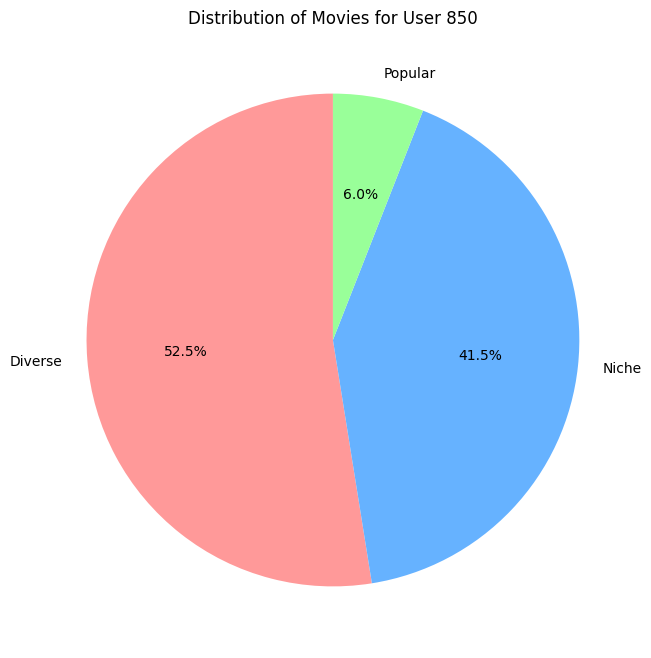

In [15]:
user_movie_counts = ratings_df[ratings_df['UserID'] == userId]['Category'].value_counts()

# Plot a pie chart
plt.figure(figsize=(8, 8))
plt.pie(user_movie_counts, labels=user_movie_counts.index, autopct='%1.1f%%', startangle=90, colors=['#FF9999', '#66B2FF', '#99FF99'])
plt.title(f'Distribution of Movies for User {userId}')
plt.show()

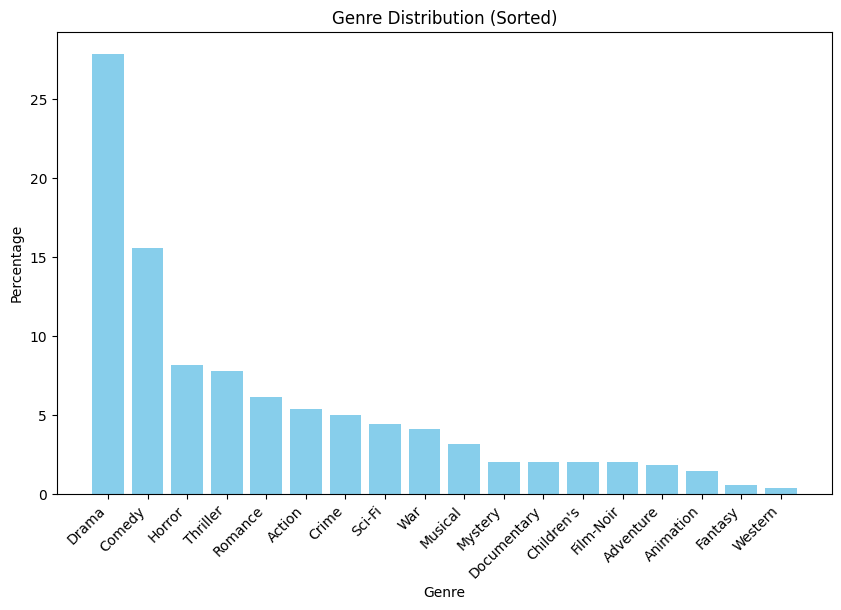

In [13]:
import pandas as pd
import matplotlib.pyplot as plt

# Assuming you have the actual_genre_distribution DataFrame with the genres as the index and percentage as the values
# Sort the genre percentages in descending order
actual_genre_distribution = actual_genre_distribution.sort_values(ascending=False)

# Create a vertical bar plot
plt.figure(figsize=(10, 6))
plt.bar(actual_genre_distribution.index, actual_genre_distribution, color='skyblue')

# Set labels and title
plt.xlabel('Genre')
plt.ylabel('Percentage')
plt.title('Genre Distribution (Sorted)')

# Rotate x-axis labels for better visibility if needed
plt.xticks(rotation=45, ha='right')

# Show the plot
plt.show()


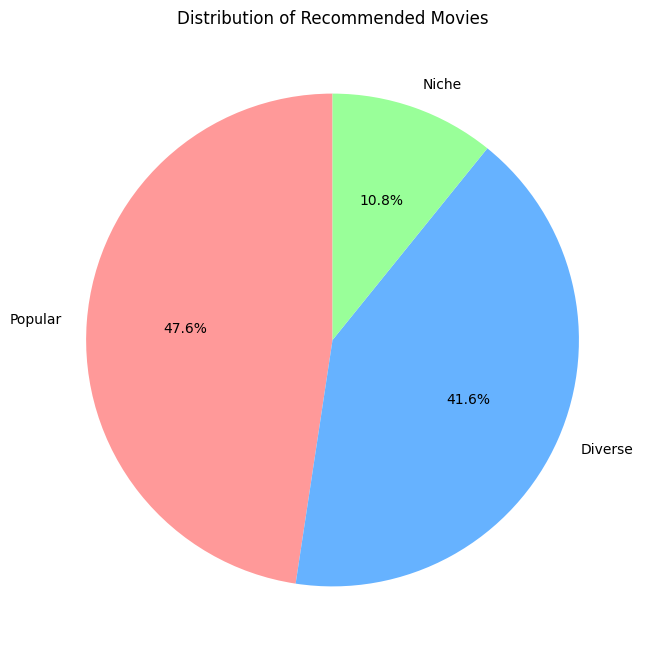

In [28]:
# Filter the DataFrame for the specified movie IDs
selected_movies_df = ratings_df[ratings_df['MovieID'].isin(top_10_rec_movies)]

# Count the number of movies in each category
category_counts = selected_movies_df['Category'].value_counts()

# Plot a pie chart
plt.figure(figsize=(8, 8))
plt.pie(category_counts, labels=category_counts.index, autopct='%1.1f%%', startangle=90, colors=['#FF9999', '#66B2FF', '#99FF99'])
plt.title('Distribution of Recommended Movies')
plt.show()

recommended
[1402, 1218, 435, 1522, 468, 1248, 1339, 1993, 1760, 2396]
recommended
Comedy       23.529412
Romance      17.647059
Thriller     11.764706
Horror       11.764706
Sci-Fi        5.882353
Action        5.882353
Crime         5.882353
Film-Noir     5.882353
Drama         5.882353
Musical       5.882353
dtype: float64


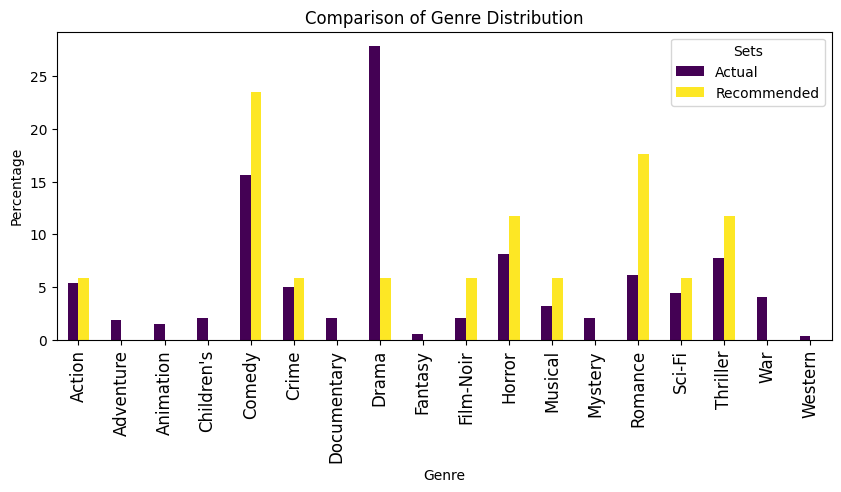

In [42]:
print("recommended")
print(top_10_rec_movies)

recommended_genre_distribution = calculate_genre_distribution(top_10_rec_movies)

print("recommended")
print(recommended_genre_distribution)
plot_grouped_genre_distribution(actual_genre_distribution, recommended_genre_distribution, title='Comparison of Genre Distribution')


### Activeness

####activeness graph

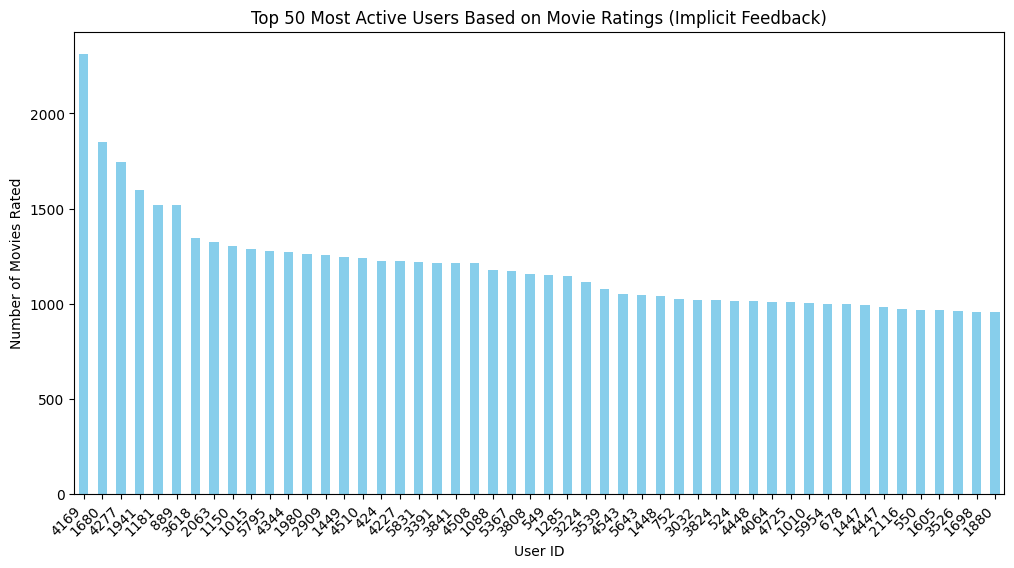

In [3]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the ratings data
data = pd.read_csv('ml-1m/ratings.dat', sep='::', engine='python', header=None, names=['UserID', 'MovieID', 'Rating', 'Timestamp'], encoding='ISO-8859-1')

# Convert ratings into implicit feedback (1 for rated, 0 for non-rated)
data['Rating'] = data['Rating'].apply(lambda x: 1 if x > 0 else 0)

# Create a user activeness DataFrame
user_activeness = data.pivot(index='UserID', columns='MovieID', values='Rating').fillna(0)
user_activeness['Activeness'] = user_activeness.sum(axis=1)

# Get the 50 most active users
top_50_active_users = user_activeness['Activeness'].nlargest(50)

# Plot the graph
plt.figure(figsize=(12, 6))
top_50_active_users.plot(kind='bar', color='skyblue')
plt.title('Top 50 Most Active Users Based on Movie Ratings (Implicit Feedback)')
plt.xlabel('User ID')
plt.ylabel('Number of Movies Rated')
plt.xticks(rotation=45, ha='right')
plt.show()


#### top active mainstream users

In [57]:
# Assuming you have the 'user_categories' and 'user_activeness' DataFrames
import pandas as pd
import matplotlib.pyplot as plt
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming you have a DataFrame with movie ratings
ratings_df = pd.read_csv('ml-1m/ratings.dat', sep='::', names=['UserID', 'MovieID', 'Rating', 'Timestamp'], engine='python', encoding='ISO-8859-1')

# Assuming you have already categorized movies into niche, diverse, and popular based on the number of ratings
# You can adjust these thresholds based on your analysis
niche_threshold = 250
diverse_threshold = 1400

# Count the number of ratings each movie received
movie_ratings_count = ratings_df['MovieID'].value_counts()

# Categorize movies
ratings_df['Category'] = 'Popular'
ratings_df.loc[ratings_df['MovieID'].isin(movie_ratings_count[movie_ratings_count <= niche_threshold].index), 'Category'] = 'Niche'
ratings_df.loc[(ratings_df['MovieID'].isin(movie_ratings_count[movie_ratings_count > niche_threshold].index)) &
                (ratings_df['MovieID'].isin(movie_ratings_count[movie_ratings_count <= diverse_threshold].index)), 'Category'] = 'Diverse'

# Calculate the number of movies watched by each user in each category
user_movie_counts = ratings_df.groupby(['UserID', 'Category']).size().unstack(fill_value=0)

# Calculate the total number of movies watched by each user
user_total_movies = user_movie_counts.sum(axis=1)

# Calculate the percentage of movies in each category for each user
user_percentage_movies = user_movie_counts.div(user_total_movies, axis=0) * 100

# Establish thresholds for categorization (adjust as needed)
niche_threshold_percentage = 30
diverse_threshold_percentage = 60

# Categorize users based on the percentage of movies in each category
user_categories = pd.Series(index=user_percentage_movies.index, dtype='object')
user_categories[user_percentage_movies['Niche'] >= niche_threshold_percentage] = 'Niche'
user_categories[(user_percentage_movies['Niche'] < niche_threshold_percentage) & (user_percentage_movies['Diverse'] >= diverse_threshold_percentage)] = 'Diverse'
user_categories[user_categories.isna()] = 'Popular'
# Load the ratings data
data = pd.read_csv('ml-1m/ratings.dat', sep='::', engine='python', header=None, names=['UserID', 'MovieID', 'Rating', 'Timestamp'], encoding='ISO-8859-1')

# Convert ratings into implicit feedback (1 for rated, 0 for non-rated)
data['Rating'] = data['Rating'].apply(lambda x: 1 if x > 0 else 0)

# Create a user activeness DataFrame
user_activeness = data.pivot(index='UserID', columns='MovieID', values='Rating').fillna(0)
user_activeness['Activeness'] = user_activeness.sum(axis=1)
user_activeness_df = user_activeness[['Activeness']].reset_index()

# Print or use the new DataFrame as needed
print(user_activeness_df)
# Filter users belonging to the "Popular" category and get the top 10 most active users
top_10_popular_users = user_activeness_df[user_activeness_df['UserID'].isin(user_categories[user_categories == 'Popular'].index)].nlargest(10, 'Activeness')

# Print or use the result as needed
print(top_10_popular_users)

popular_user_ids = top_10_popular_users['UserID'].tolist()

# Print or use the list as needed
print(popular_user_ids)



MovieID  UserID  Activeness
0             1        53.0
1             2       129.0
2             3        51.0
3             4        21.0
4             5       198.0
...         ...         ...
6035       6036       888.0
6036       6037       202.0
6037       6038        20.0
6038       6039       123.0
6039       6040       341.0

[6040 rows x 2 columns]
MovieID  UserID  Activeness
234         235       440.0
5076       5077       424.0
3545       3546       410.0
4789       4790       378.0
1278       1279       361.0
2128       2129       357.0
2912       2913       330.0
5268       5269       324.0
3300       3301       310.0
3298       3299       302.0
[235, 5077, 3546, 4790, 1279, 2129, 2913, 5269, 3301, 3299]


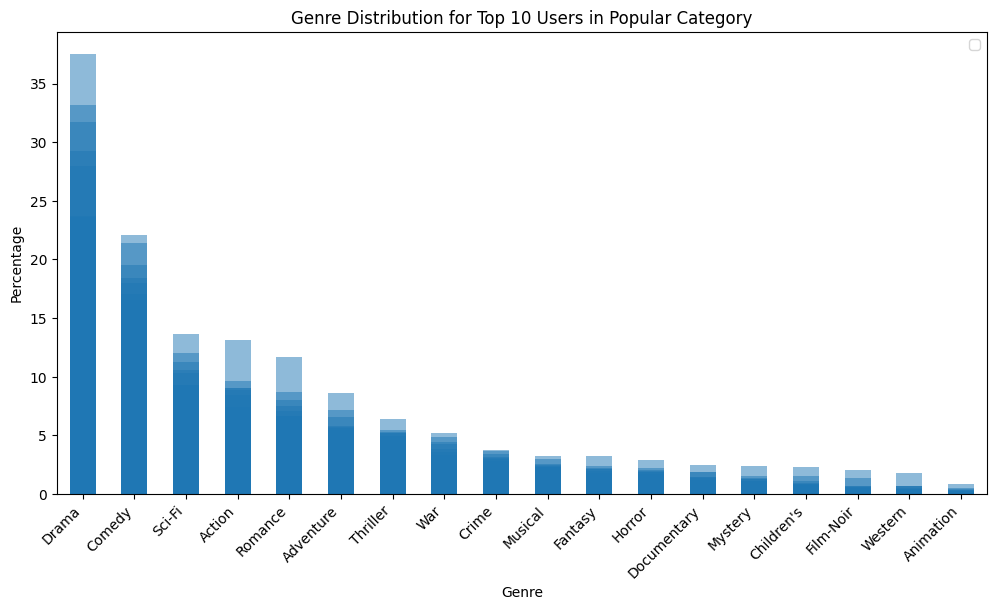

In [60]:
import pandas as pd
import matplotlib.pyplot as plt

# Assuming you have the 'calculate_genre_distribution' function
movies = pd.read_csv('ml-1m/movies.dat', sep='::', names=['MovieID', 'Title', 'genres'], engine='python', encoding='ISO-8859-1')

# Assuming you have the 'popular_user_ids' list from the previous code

# Plot genre distribution for each of the top 10 popular users
plt.figure(figsize=(12, 6))
for user_id in popular_user_ids:
    # Get the movies interacted by the user
    user_movies = user_activeness.loc[user_id][user_activeness.loc[user_id] > 0].index.tolist()

    # Calculate genre distribution for the user
    user_genre_distribution = calculate_genre_distribution(user_movies)

    # Plot the user's genre distribution
    user_genre_distribution.plot(kind='bar', alpha=0.5)

plt.title('Genre Distribution for Top 10 Users in Popular Category')
plt.xlabel('Genre')
plt.ylabel('Percentage')
plt.legend()
plt.xticks(rotation=45, ha='right')
plt.show()


###Genre distribution for recommended movies

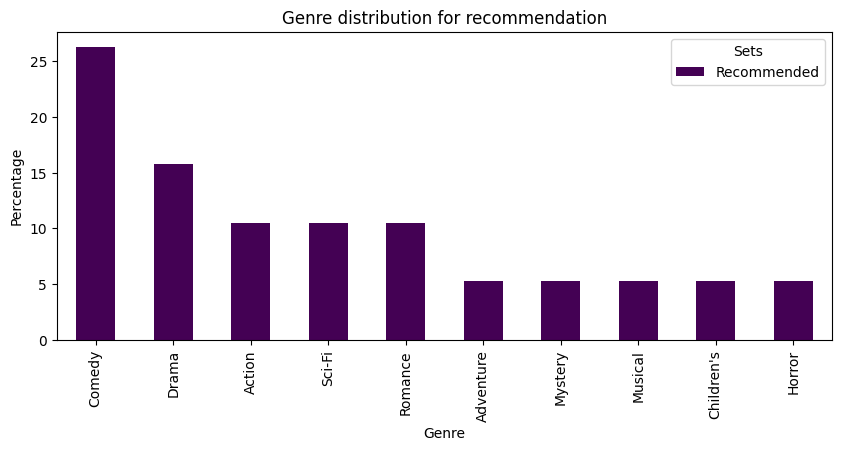

In [45]:
rec_genre_distribution=calculate_genre_distribution(top_10_rec_movies)

df = pd.DataFrame({'Recommended': rec_genre_distribution})

# Create a bar plot
ax = df.plot(kind='bar', stacked=False, colormap='viridis', figsize=(10, 4))

# Set labels and title
ax.set_xlabel('Genre')
ax.set_ylabel('Percentage')
ax.set_title('Genre distribution for recommendation')

# # Set x-axis labels
# if labels:
#     ax.set_xticklabels(labels, rotation=45, ha='right')

# Display the legend
ax.legend(title='Sets')

# Show the plot
plt.show()